Context-Engineering：多步 LLM 交互的控制循环
==========================================

本模块演示如何实现控制流机制，以编排复杂的多步 LLM 交互。在前面笔记本中的上下文扩展技术基础上，我们现在探索以下模式：

1. 顺序链式（一个步骤的输出 → 下一个步骤的输入）
2. 迭代优化（通过循环不断改进响应）
3. 条件分支（根据 LLM 输出走不同路径）
4. 自我批评与修正（对输出进行元评估）
5. 外部验证循环（使用工具/知识进行验证）

这些模式的实现重点在于令牌效率和跨步骤保持上下文一致性。

用法：
    # 在 Jupyter 或 Colab 中：
    %run 03_control_loops.py
    # 或
    from control_loops import SequentialChain, IterativeRefiner, ConditionalBrancher


In [22]:
import os
import re
import json
import time
import tiktoken
from typing import Dict, List, Tuple, Any, Optional, Union, Callable, TypeVar

# 更好的类型提示的类型变量
T = TypeVar('T')
Response = Union[str, Dict[str, Any]]

# 用于日志记录和可视化
import logging
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# # 设置 API 客户端
try:
    from openai import OpenAI
    OPENAI_AVAILABLE = True
except ImportError:
    OPENAI_AVAILABLE = False
    logger.warning("未找到 OpenAI 包。请安装：pip install openai")

try:
    import dotenv
    dotenv.load_dotenv()
    ENV_LOADED = True
except ImportError:
    ENV_LOADED = False
    logger.warning("未找到 python-dotenv。请安装：pip install python-dotenv")

# 常量
DEFAULT_MODEL = "openai/gpt-4.1"
DEFAULT_TEMPERATURE = 0.7
DEFAULT_MAX_TOKENS = 500

# 辅助函数
# ================

def setup_client(api_key=None, model=DEFAULT_MODEL):
    """
    设置用于 LLM 交互的 API 客户端。

    参数：
        api_key: API 密钥（如果为 None，将在环境变量中查找 OPENAI_API_KEY）
        model: 要使用的模型名称

    返回：
        tuple: (客户端, 模型名称)
    """
    if api_key is None:
        api_key = os.environ.get("GITHUB_TOKEN")
        if api_key is None and not ENV_LOADED:
            logger.warning("未找到 API 密钥。请设置 OPENAI_API_KEY 环境变量或传递 api_key 参数。")
    
    if OPENAI_AVAILABLE:
        client = OpenAI(
            base_url="https://models.github.ai/inference",
            api_key=api_key,
        )
        return client, model
    else:
        logger.error("需要 OpenAI 包。请安装：pip install openai")
        return None, model


def count_tokens(text: str, model: str = "cl100k_base") -> int:
    """
    使用适当的分词器计算文本字符串中的令牌数。

    参数：
        text: 要分词的文本
        model: 用于分词的模型名称

    返回：
        int: 令牌数量
    """
    try:
        encoding = tiktoken.get_encoding("cl100k_base")
        return len(encoding.encode(text))
    except Exception as e:
        # 当 tiktoken 不支持该模型时的回退方案
        logger.warning(f"无法为 {model} 使用 tiktoken：{e}")
        # 粗略估算：英文中 1 个令牌 ≈ 4 个字符
        return len(text) // 4


def generate_response(
    prompt: str,
    client=None,
    model: str = DEFAULT_MODEL,
    temperature: float = DEFAULT_TEMPERATURE,
    max_tokens: int = DEFAULT_MAX_TOKENS,
    system_message: str = "你是一个有用的助手。"
) -> Tuple[str, Dict[str, Any]]:
    """
    从 LLM 生成响应并返回元数据。

    参数：
        prompt: 要发送的提示
        client: API 客户端（如果为 None，将创建一个）
        model: 模型名称
        temperature: 温度参数
        max_tokens: 生成的最大令牌数
        system_message: 要使用的系统消息

    返回：
        tuple: (响应文本, 元数据)
    """
    if client is None:
        client, model = setup_client(model=model)
        if client is None:
            return "错误：没有可用的 API 客户端", {"error": "没有 API 客户端"}
    
    prompt_tokens = count_tokens(prompt, model)
    system_tokens = count_tokens(system_message, model)
    
    metadata = {
        "prompt_tokens": prompt_tokens,
        "system_tokens": system_tokens,
        "model": model,
        "temperature": temperature,
        "max_tokens": max_tokens,
        "timestamp": time.time()
    }
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": prompt}
            ],
            temperature=temperature,
            max_tokens=max_tokens
        )
        latency = time.time() - start_time
        
        response_text = response.choices[0].message.content
        response_tokens = count_tokens(response_text, model)
        
        metadata.update({
            "latency": latency,
            "response_tokens": response_tokens,
            "total_tokens": prompt_tokens + system_tokens + response_tokens,
            "token_efficiency": response_tokens / (prompt_tokens + system_tokens) if (prompt_tokens + system_tokens) > 0 else 0,
            "tokens_per_second": response_tokens / latency if latency > 0 else 0
        })
        
        return response_text, metadata
    
    except Exception as e:
        logger.error(f"生成响应时出错：{e}")
        metadata["error"] = str(e)
        return f"错误：{str(e)}", metadata


def format_metrics(metrics: Dict[str, Any]) -> str:
    """
    将指标字典格式化为可读字符串。
    
    参数：
        metrics: 指标字典
        
    返回：
        str: 格式化的指标字符串
    """
    # 选择要显示的最重要的指标
    key_metrics = {
        "提示令牌数": metrics.get("prompt_tokens", 0),
        "响应令牌数": metrics.get("response_tokens", 0),
        "总令牌数": metrics.get("total_tokens", 0),
        "延迟": f"{metrics.get('latency', 0):.2f}秒",
        "令牌效率": f"{metrics.get('token_efficiency', 0):.2f}"
    }
    
    return " | ".join([f"{k}: {v}" for k, v in key_metrics.items()])


def display_response(
    prompt: str,
    response: str,
    metrics: Dict[str, Any],
    show_prompt: bool = True
) -> None:
    """
    在笔记本中显示提示-响应对和指标。
    
    参数：
        prompt: 提示文本
        response: 响应文本
        metrics: 指标字典
        show_prompt: 是否显示提示文本
    """
    if show_prompt:
        display(HTML("<h4>提示：</h4>"))
        display(Markdown(f"```\n{prompt}\n```"))
    
    display(HTML("<h4>响应：</h4>"))
    display(Markdown(response))
    
    display(HTML("<h4>指标：</h4>"))
    display(Markdown(f"```\n{format_metrics(metrics)}\n```"))


In [14]:
# 控制循环基类
# =========================

class ControlLoop:
    """
    所有控制循环实现的基类。
    提供跟踪指标和历史记录的通用功能。
    """
    
    def __init__(
        self,
        client=None,
        model: str = DEFAULT_MODEL,
        system_message: str = "您是一个有帮助的助手。",
        max_tokens: int = DEFAULT_MAX_TOKENS,
        temperature: float = DEFAULT_TEMPERATURE,
        verbose: bool = False
    ):
        """
        初始化控制循环。
        
        参数:
            client: API客户端（如果为None，将创建一个）
            model: 要使用的模型名称
            system_message: 要使用的系统消息
            max_tokens: 生成的最大令牌数
            temperature: 温度参数
            verbose: 是否打印调试信息
        """
        self.client, self.model = setup_client(model=model) if client is None else (client, model)
        self.system_message = system_message
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.verbose = verbose
        
        # 初始化历史记录和指标跟踪
        self.history = []
        self.metrics = {
            "total_prompt_tokens": 0,
            "total_response_tokens": 0,
            "total_tokens": 0,
            "total_latency": 0,
            "steps": 0
        }
    
    def _log(self, message: str) -> None:
        """
        如果启用了详细模式，则记录消息。
        
        参数:
            message: 要记录的消息
        """
        if self.verbose:
            logger.info(message)
    
    def _call_llm(
        self,
        prompt: str,
        custom_system_message: Optional[str] = None
    ) -> Tuple[str, Dict[str, Any]]:
        """
        调用LLM并更新指标。
        
        参数:
            prompt: 要发送的提示
            custom_system_message: 覆盖系统消息（可选）
            
        返回:
            tuple: (响应文本, 元数据)
        """
        system_msg = custom_system_message if custom_system_message else self.system_message
        
        response, metadata = generate_response(
            prompt=prompt,
            client=self.client,
            model=self.model,
            temperature=self.temperature,
            max_tokens=self.max_tokens,
            system_message=system_msg
        )
        
        # 更新指标
        self.metrics["total_prompt_tokens"] += metadata.get("prompt_tokens", 0)
        self.metrics["total_response_tokens"] += metadata.get("response_tokens", 0)
        self.metrics["total_tokens"] += metadata.get("total_tokens", 0)
        self.metrics["total_latency"] += metadata.get("latency", 0)
        self.metrics["steps"] += 1
        
        # 添加到历史记录
        step_record = {
            "prompt": prompt,
            "response": response,
            "metrics": metadata,
            "timestamp": time.time()
        }
        self.history.append(step_record)
        
        return response, metadata
    
    def get_summary_metrics(self) -> Dict[str, Any]:
        """
        获取所有步骤的汇总指标。
        
        返回:
            dict: 汇总指标
        """
        summary = self.metrics.copy()
        
        # 添加派生指标
        if summary["steps"] > 0:
            summary["avg_latency_per_step"] = summary["total_latency"] / summary["steps"]
            
        if summary["total_prompt_tokens"] > 0:
            summary["overall_efficiency"] = (
                summary["total_response_tokens"] / summary["total_prompt_tokens"]
            )
        
        return summary
    
    def visualize_metrics(self) -> None:
        """
        创建跨步骤的指标可视化。
        """
        if not self.history:
            logger.warning("没有可视化的历史记录")
            return
        
        # 提取绘图数据
        steps = list(range(1, len(self.history) + 1))
        prompt_tokens = [h["metrics"].get("prompt_tokens", 0) for h in self.history]
        response_tokens = [h["metrics"].get("response_tokens", 0) for h in self.history]
        latencies = [h["metrics"].get("latency", 0) for h in self.history]
        efficiencies = [h["metrics"].get("token_efficiency", 0) for h in self.history]

        # 设置中文字体
        plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False
        
        # 创建图形
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle("按步骤划分的控制循环指标", fontsize=16)
        
        # 图1：令牌使用
        axes[0, 0].bar(steps, prompt_tokens, label="提示令牌", color="blue", alpha=0.7)
        axes[0, 0].bar(steps, response_tokens, bottom=prompt_tokens, label="响应令牌", 
                       color="green", alpha=0.7)
        axes[0, 0].set_title("令牌使用")
        axes[0, 0].set_xlabel("步骤")
        axes[0, 0].set_ylabel("令牌数")
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # 图2：延迟
        axes[0, 1].plot(steps, latencies, marker='o', color="red", alpha=0.7)
        axes[0, 1].set_title("延迟")
        axes[0, 1].set_xlabel("步骤")
        axes[0, 1].set_ylabel("秒数")
        axes[0, 1].grid(alpha=0.3)
        
        # 图3：令牌效率
        axes[1, 0].plot(steps, efficiencies, marker='s', color="purple", alpha=0.7)
        axes[1, 0].set_title("令牌效率（响应/提示）")
        axes[1, 0].set_xlabel("步骤")
        axes[1, 0].set_ylabel("比率")
        axes[1, 0].grid(alpha=0.3)
        
        # 图4：累积令牌数
        cumulative_tokens = np.cumsum([h["metrics"].get("total_tokens", 0) for h in self.history])
        axes[1, 1].plot(steps, cumulative_tokens, marker='^', color="orange", alpha=0.7)
        axes[1, 1].set_title("累积令牌使用")
        axes[1, 1].set_xlabel("步骤")
        axes[1, 1].set_ylabel("总令牌数")
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()


class SequentialChain(ControlLoop):
    """
    一个顺序链式控制循环，将多个步骤串联起来，每一步的输出作为下一步的输入。
    """
    
    def __init__(self, steps: List[Dict[str, Any]], **kwargs):
        """
        初始化顺序链。
        
        参数:
            steps: 步骤配置列表，每个包含：
                - prompt_template: 带有 {input} 占位符的字符串
                - system_message: （可选）自定义系统消息
                - name: （可选）步骤名称
            **kwargs: 传递给 ControlLoop 的其他参数
        """
        super().__init__(**kwargs)
        self.steps = steps
        self._validate_steps()
    
    def _validate_steps(self) -> None:
        """校验步骤配置。"""
        for i, step in enumerate(self.steps):
            if "prompt_template" not in step:
                raise ValueError(f"第 {i} 步缺少 'prompt_template'")
            
            # 确保每步有名称
            if "name" not in step:
                step["name"] = f"step_{i+1}"
    
    def run(self, initial_input: str) -> Tuple[str, Dict[str, Any]]:
        """
        使用初始输入运行顺序链。
        
        参数:
            initial_input: 第一步的输入
            
        返回:
            tuple: (最终输出, 所有步骤输出)
        """
        current_input = initial_input
        all_outputs = {"initial_input": initial_input}
        
        for i, step in enumerate(self.steps):
            step_name = step["name"]
            self._log(f"运行第 {i+1}/{len(self.steps)} 步: {step_name}")
            
            # 使用当前输入格式化提示
            prompt = step["prompt_template"].format(input=current_input)
            system_message = step.get("system_message", self.system_message)
            
            # 调用 LLM
            response, metadata = self._call_llm(prompt, system_message)
            
            # 保存输出
            all_outputs[step_name] = {
                "prompt": prompt,
                "response": response,
                "metrics": metadata
            }
            
            # 更新下一步输入
            current_input = response
        
        return current_input, all_outputs
    
    def display_chain_results(self, all_outputs: Dict[str, Any]) -> None:
        """
        在笔记本中展示链式步骤的结果。
        
        参数:
            all_outputs: run() 的输出字典
        """
        display(HTML("<h2>顺序链结果展示</h2>"))
        
        # 展示初始输入
        display(HTML("<h3>初始输入</h3>"))
        display(Markdown(all_outputs["initial_input"]))
        
        # 展示每一步
        for i, step in enumerate(self.steps):
            step_name = step["name"]
            if step_name in all_outputs:
                step_output = all_outputs[step_name]
                
                display(HTML(f"<h3>第 {i+1} 步: {step_name}</h3>"))
                
                # 展示提示
                display(HTML("<h4>提示：</h4>"))
                display(Markdown(f"```\n{step_output['prompt']}\n```"))
                
                # 展示响应
                display(HTML("<h4>响应：</h4>"))
                display(Markdown(step_output["response"]))
                
                # 展示指标
                display(HTML("<h4>指标：</h4>"))
                display(Markdown(f"```\n{format_metrics(step_output['metrics'])}\n```"))
        
        # 展示汇总指标
        display(HTML("<h3>汇总指标</h3>"))
        summary = self.get_summary_metrics()
        display(Markdown(f"""
        - 总步骤数: {summary['steps']}
        - 总令牌数: {summary['total_tokens']}
        - 总延迟: {summary['total_latency']:.2f}秒
        - 每步平均延迟: {summary.get('avg_latency_per_step', 0):.2f}秒
        - 总体效率: {summary.get('overall_efficiency', 0):.2f}
        """))


class IterativeRefiner(ControlLoop):
    """
    一个迭代式细化控制循环，通过多轮反馈和改进不断优化输出，直到满足停止条件。
    """
    
    def __init__(
        self,
        max_iterations: int = 5,
        refinement_template: str = "请改进以下文本：{previous_response}\n\n需要的具体改进：{feedback}",
        feedback_template: str = "请评估此回答的质量，并提出具体改进建议：{response}",
        stopping_condition: Optional[Callable[[str, Dict[str, Any]], bool]] = None,
        **kwargs
    ):
        """
        初始化迭代细化器。
        
        参数:
            max_iterations: 最大细化轮数
            refinement_template: 细化提示模板
            feedback_template: 生成反馈的提示模板
            stopping_condition: 判断是否停止细化的函数，参数为 (response, metadata)，返回 True 时停止
            **kwargs: 传递给 ControlLoop 的其他参数
        """
        super().__init__(**kwargs)
        self.max_iterations = max_iterations
        self.refinement_template = refinement_template
        self.feedback_template = feedback_template
        self.stopping_condition = stopping_condition
    
    def generate_feedback(self, response: str) -> Tuple[str, Dict[str, Any]]:
        """
        针对当前回答生成反馈。
        
        参数:
            response: 当前需要评估的回答
            
        返回:
            tuple: (反馈文本, 元数据)
        """
        prompt = self.feedback_template.format(response=response)
        return self._call_llm(prompt)
    
    def refine_response(
        self,
        previous_response: str,
        feedback: str
    ) -> Tuple[str, Dict[str, Any]]:
        """
        根据反馈细化回答。
        
        参数:
            previous_response: 需要细化的上一次回答
            feedback: 用于细化的反馈内容
            
        返回:
            tuple: (细化后的回答, 元数据)
        """
        prompt = self.refinement_template.format(
            previous_response=previous_response,
            feedback=feedback
        )
        return self._call_llm(prompt)
    
    def run(
        self,
        initial_prompt: str,
        use_auto_feedback: bool = True
    ) -> Tuple[str, Dict[str, List[Dict[str, Any]]]]:
        """
        执行迭代细化流程。
        
        参数:
            initial_prompt: 首次生成回答的提示
            use_auto_feedback: 是否自动生成反馈（如为 False，则需手动输入反馈）
                              
        返回:
            tuple: (最终回答, 细化历史)
        """
        # 生成初始回答
        self._log("生成初始回答")
        current_response, metadata = self._call_llm(initial_prompt)
        
        refinement_history = {
            "initial": {
                "prompt": initial_prompt,
                "response": current_response,
                "metrics": metadata
            },
            "iterations": []
        }
        
        # 迭代细化循环
        iteration = 0
        should_continue = True
        
        while should_continue and iteration < self.max_iterations:
            iteration += 1
            self._log(f"细化轮次 {iteration}/{self.max_iterations}")
            
            # 生成反馈
            if use_auto_feedback:
                feedback, feedback_metadata = self.generate_feedback(current_response)
                self._log(f"自动反馈：{feedback}")
            else:
                # 手动反馈模式
                print(f"\n\n当前回答（第 {iteration} 轮）：")
                print("-" * 80)
                print(current_response)
                print("-" * 80)
                feedback = input("请输入您的反馈（输入 'stop' 结束细化）：")
                
                if feedback.lower() == 'stop':
                    break
                
                feedback_metadata = {"manual": True}
            
            # 细化回答
            refined_response, refine_metadata = self.refine_response(current_response, feedback)
            
            # 记录本轮细化
            refinement_history["iterations"].append({
                "iteration": iteration,
                "feedback": feedback,
                "feedback_metrics": feedback_metadata,
                "refined_response": refined_response,
                "refinement_metrics": refine_metadata
            })
            
            # 更新当前回答
            current_response = refined_response
            
            # 检查停止条件
            if self.stopping_condition:
                should_continue = not self.stopping_condition(current_response, refine_metadata)
        
        return current_response, refinement_history
    
    def display_refinement_history(self, refinement_history: Dict[str, Any]) -> None:
        """
        在笔记本中展示细化历史。
        
        参数:
            refinement_history: run() 返回的细化历史
        """
        display(HTML("<h2>迭代细化结果</h2>"))
        
        # 展示初始提示和回答
        display(HTML("<h3>初始提示</h3>"))
        display(Markdown(f"```\n{refinement_history['initial']['prompt']}\n```"))
        
        display(HTML("<h3>初始回答</h3>"))
        display(Markdown(refinement_history['initial']['response']))
        
        # 展示每轮细化
        for iteration in refinement_history["iterations"]:
            iteration_num = iteration["iteration"]
            
            display(HTML(f"<h3>第 {iteration_num} 轮</h3>"))
            
            # 展示反馈
            display(HTML("<h4>反馈：</h4>"))
            display(Markdown(iteration["feedback"]))
            
            # 展示细化后的回答
            display(HTML("<h4>细化后回答：</h4>"))
            display(Markdown(iteration["refined_response"]))
            
            # 展示指标
            display(HTML("<h4>指标：</h4>"))
            metrics = iteration["refinement_metrics"]
            display(Markdown(f"```\n{format_metrics(metrics)}\n```"))
        
        # 展示汇总
        display(HTML("<h3>细化汇总</h3>"))
        total_iterations = len(refinement_history["iterations"])
        display(Markdown(f"""
        - 初始提示令牌数: {refinement_history['initial']['metrics']['prompt_tokens']}
        - 初始回答令牌数: {refinement_history['initial']['metrics']['response_tokens']}
        - 总细化轮数: {total_iterations}
        - 最终回答令牌数: {refinement_history['iterations'][-1]['refinement_metrics']['response_tokens'] if total_iterations > 0 else refinement_history['initial']['metrics']['response_tokens']}
        """))


class ConditionalBrancher(ControlLoop):
    """
    一个实现条件分支的控制循环，根据LLM输出进行不同的执行路径选择。
    """
    
    def __init__(
        self,
        branches: Dict[str, Dict[str, Any]],
        classifier_template: str = "分析以下输入，并将其精确分类为以下类别之一：{categories}。\n\n输入：{input}\n\n类别：",
        **kwargs
    ):
        """
        初始化条件分支器。
        
        参数:
            branches: 分支名称到配置的字典，每个配置包含：
                - prompt_template: 带有 {input} 占位符的字符串
                - system_message: （可选）自定义系统消息
            classifier_template: 分类提示模板
            **kwargs: 传递给 ControlLoop 的其他参数
        """
        super().__init__(**kwargs)
        self.branches = branches
        self.classifier_template = classifier_template
        self._validate_branches()
    
    def _validate_branches(self) -> None:
        """校验分支配置。"""
        if not self.branches:
            raise ValueError("未定义分支")
        
        for branch_name, config in self.branches.items():
            if "prompt_template" not in config:
                raise ValueError(f"分支 '{branch_name}' 缺少 'prompt_template'")
    
    def classify_input(self, input_text: str) -> Tuple[str, Dict[str, Any]]:
        """
        对输入进行分类以确定选择哪个分支。
        
        参数:
            input_text: 需要分类的输入文本
            
        返回:
            tuple: (分支名称, 元数据)
        """
        categories = list(self.branches.keys())
        categories_str = ", ".join(categories)
        
        prompt = self.classifier_template.format(
            categories=categories_str,
            input=input_text
        )
        
        # 分类时使用专用系统消息
        system_message = "你是一个分类器，能够精确地对输入进行分类。"
        response, metadata = self._call_llm(prompt, system_message)
        
        # 尝试精确匹配类别
        for category in categories:
            if category.lower() in response.lower():
                return category, metadata
        
        # 如果没有精确匹配，则取第一行并寻找最接近的类别
        first_line = response.strip().split('\n')[0].lower()
        
        best_match = None
        best_score = 0
        
        for category in categories:
            # 简单的字符串相似度评分
            cat_lower = category.lower()
            matches = sum(c in first_line for c in cat_lower)
            score = matches / len(cat_lower) if len(cat_lower) > 0 else 0
            
            if score > best_score:
                best_score = score
                best_match = category
        
        if best_match and best_score > 0.5:
            return best_match, metadata
        
        # 如果没有匹配则回退到第一个分支
        self._log(f"警告：无法分类输入，使用第一个分支：{categories[0]}")
        return categories[0], metadata
    
    def execute_branch(
        self,
        branch_name: str,
        input_text: str
    ) -> Tuple[str, Dict[str, Any]]:
        """
        使用指定输入执行某个分支。
        
        参数:
            branch_name: 要执行的分支名称
            input_text: 分支的输入文本
            
        返回:
            tuple: (响应, 元数据)
        """
        if branch_name not in self.branches:
            raise ValueError(f"未知分支: {branch_name}")
        
        branch_config = self.branches[branch_name]
        prompt = branch_config["prompt_template"].format(input=input_text)
        system_message = branch_config.get("system_message", self.system_message)
        
        return self._call_llm(prompt, system_message)
    
    def run(
        self,
        input_text: str,
        branch_name: Optional[str] = None
    ) -> Tuple[str, Dict[str, Any]]:
        """
        执行条件分支流程。
        
        参数:
            input_text: 要处理的输入文本
            branch_name: 可选，指定分支（跳过分类）
            
        返回:
            tuple: (响应, 运行详情)
        """
        run_details = {"input": input_text}
        
        # 如果未指定分支则进行分类
        if branch_name is None:
            self._log("正在分类输入")
            branch_name, classification_metadata = self.classify_input(input_text)
            run_details["classification"] = {
                "branch": branch_name,
                "metrics": classification_metadata
            }
        
        self._log(f"执行分支: {branch_name}")
        
        # 执行选定分支
        response, metadata = self.execute_branch(branch_name, input_text)
        
        run_details["execution"] = {
            "branch": branch_name,
            "response": response,
            "metrics": metadata
        }
        
        return response, run_details
    
    def display_branching_results(self, run_details: Dict[str, Any]) -> None:
        """
        在笔记本中展示条件分支结果。
        
        参数:
            run_details: run() 的运行详情
        """
        display(HTML("<h2>条件分支结果</h2>"))
        
        # 展示输入
        display(HTML("<h3>输入</h3>"))
        display(Markdown(run_details["input"]))
        
        # 展示分类结果
        if "classification" in run_details:
            display(HTML("<h3>分类结果</h3>"))
            branch = run_details["classification"]["branch"]
            display(Markdown(f"选定分支: **{branch}**"))
            
            # 展示分类指标
            display(HTML("<h4>分类指标：</h4>"))
            metrics = run_details["classification"]["metrics"]
            display(Markdown(f"```\n{format_metrics(metrics)}\n```"))
        
        # 展示分支执行结果
        display(HTML("<h3>分支执行结果</h3>"))
        display(HTML("<h4>分支：</h4>"))
        display(Markdown(f"**{run_details['execution']['branch']}**"))
        
        display(HTML("<h4>响应：</h4>"))
        display(Markdown(run_details["execution"]["response"]))
        
        display(HTML("<h4>执行指标：</h4>"))
        metrics = run_details["execution"]["metrics"]
        display(Markdown(f"```\n{format_metrics(metrics)}\n```"))


class SelfCritique(ControlLoop):
    """
    一个自我批评控制循环，先生成回答，然后对其进行批评和改进，
    在单次流程中完成，无需多次API调用进行细化。
    """
    
    def __init__(
        self,
        critique_template: str = "步骤1：针对问题生成回答。\n步骤2：对你的回答进行批评，指出任何错误、遗漏或可改进之处。\n步骤3：根据你的批评，给出最终改进后的回答。\n\n问题：{input}",
        parse_sections: bool = True,
        **kwargs
    ):
        """
        初始化自我批评控制循环。
        
        参数:
            critique_template: 自我批评提示模板
            parse_sections: 是否将响应解析为各个部分
            **kwargs: 传递给 ControlLoop 的其他参数
        """
        super().__init__(**kwargs)
        self.critique_template = critique_template
        self.parse_sections = parse_sections
    
    def run(self, input_text: str) -> Tuple[str, Dict[str, Any]]:
        """
        执行自我批评流程。
        
        参数:
            input_text: 需要回答的问题
            
        返回:
            tuple: (最终回答, 运行详情)
        """
        # 格式化提示
        prompt = self.critique_template.format(input=input_text)
        
        # 生成自我批评响应
        response, metadata = self._call_llm(prompt)
        
        # 如需解析部分则尝试解析
        sections = {}
        if self.parse_sections:
            # 尝试解析初始回答、批评和最终回答
            initial_match = re.search(r"步骤1:(.*?)步骤2:", response, re.DOTALL)
            critique_match = re.search(r"步骤2:(.*?)步骤3:", response, re.DOTALL)
            final_match = re.search(r"步骤3:(.*?)$", response, re.DOTALL)
            
            if initial_match:
                sections["initial_response"] = initial_match.group(1).strip()
            if critique_match:
                sections["critique"] = critique_match.group(1).strip()
            if final_match:
                sections["final_response"] = final_match.group(1).strip()
        
        # 如果解析失败，则使用完整响应
        if not sections and self.parse_sections:
            self._log("未能从响应中解析出各部分")
            sections["full_response"] = response
        
        # 构建运行详情
        run_details = {
            "input": input_text,
            "full_response": response,
            "sections": sections,
            "metrics": metadata
        }
        
        # 返回最终回答（如解析失败则返回完整响应）
        final_response = sections.get("final_response", response)
        return final_response, run_details
    
    def display_results(self, run_details: Dict[str, Any]) -> None:
        """
        在笔记本中展示自我批评结果。
        
        参数:
            run_details: run() 的运行详情
        """
        display(HTML("<h2>自我批评结果</h2>"))
        
        # 展示输入
        display(HTML("<h3>输入</h3>"))
        display(Markdown(run_details["input"]))
        
        # 如有解析部分则展示
        if "sections" in run_details and run_details["sections"]:
            sections = run_details["sections"]
            
            if "initial_response" in sections:
                display(HTML("<h3>初始回答</h3>"))
                display(Markdown(sections["initial_response"]))
            
            if "critique" in sections:
                display(HTML("<h3>自我批评</h3>"))
                display(Markdown(sections["critique"]))
            
            if "final_response" in sections:
                display(HTML("<h3>最终回答</h3>"))
                display(Markdown(sections["final_response"]))
        
        # 如果没有解析部分则展示完整响应
        elif "full_response" in run_details:
            display(HTML("<h3>完整响应</h3>"))
            display(Markdown(run_details["full_response"]))
        
        # 展示指标
        display(HTML("<h3>指标</h3>"))
        metrics = run_details["metrics"]
        display(Markdown(f"```\n{format_metrics(metrics)}\n```"))


class ExternalValidation(ControlLoop):
    """
    一个使用外部工具或知识对LLM响应进行验证和纠正的控制循环，形成闭环反馈。
    """
    
    def __init__(
        self,
        validator_fn: Callable[[str], Tuple[bool, str]],
        correction_template: str = "你的上一个回答存在一些问题：\n\n{validation_feedback}\n\n请纠正你的回答以解决这些问题：\n\n{previous_response}",
        max_attempts: int = 3,
        **kwargs
    ):
        """
        初始化外部验证循环。
        
        参数:
            validator_fn: 一个函数，输入为响应，返回 (是否有效, 反馈信息)
            correction_template: 纠正提示的模板
            max_attempts: 最大验证尝试次数
            **kwargs: 传递给 ControlLoop 的其他参数
        """
        super().__init__(**kwargs)
        self.validator_fn = validator_fn
        self.correction_template = correction_template
        self.max_attempts = max_attempts
    
    def run(self, input_text: str) -> Tuple[str, Dict[str, Any]]:
        """
        执行外部验证流程。
        
        参数:
            input_text: 需要回答的输入
            
        返回:
            tuple: (最终回答, 运行详情)
        """
        # 生成初始回答
        response, metadata = self._call_llm(input_text)
        
        attempts = []
        current_response = response
        is_valid = False
        validation_feedback = ""
        
        # 添加初始尝试
        attempts.append({
            "attempt": 1,
            "response": current_response,
            "metrics": metadata,
            "validation": {
                "pending": True
            }
        })
        
        # 验证循环
        for attempt in range(1, self.max_attempts + 1):
            # 验证当前回答
            self._log(f"正在验证第 {attempt} 次尝试")
            is_valid, validation_feedback = self.validator_fn(current_response)
            
            # 更新当前尝试的验证结果
            attempts[-1]["validation"] = {
                "is_valid": is_valid,
                "feedback": validation_feedback,
                "pending": False
            }
            
            # 如果有效则停止
            if is_valid:
                self._log(f"第 {attempt} 次尝试获得有效回答")
                break
            
            # 达到最大尝试次数则停止
            if attempt >= self.max_attempts:
                self._log(f"已达到最大尝试次数 ({self.max_attempts})，仍未获得有效回答")
                break
            
            # 构建纠正提示
            self._log(f"尝试纠正（第 {attempt+1} 次尝试）")
            correction_prompt = self.correction_template.format(
                validation_feedback=validation_feedback,
                previous_response=current_response
            )
            
            # 生成纠正后的回答
            corrected_response, correction_metadata = self._call_llm(correction_prompt)
            current_response = corrected_response
            
            # 添加新尝试
            attempts.append({
                "attempt": attempt + 1,
                "response": current_response,
                "metrics": correction_metadata,
                "validation": {
                    "pending": True
                }
            })
        
        # 构建运行详情
        run_details = {
            "input": input_text,
            "attempts": attempts,
            "final_response": current_response,
            "is_valid": is_valid,
            "validation_feedback": validation_feedback,
            "attempts_count": len(attempts)
        }
        
        return current_response, run_details
    
    def display_results(self, run_details: Dict[str, Any]) -> None:
        """
        在笔记本中展示外部验证结果。
        
        参数:
            run_details: run() 的运行详情
        """
        display(HTML("<h2>外部验证结果</h2>"))
        
        # 展示输入
        display(HTML("<h3>输入</h3>"))
        display(Markdown(run_details["input"]))
        
        # 展示每次尝试
        for attempt_data in run_details["attempts"]:
            attempt_num = attempt_data["attempt"]
            display(HTML(f"<h3>第 {attempt_num} 次尝试</h3>"))
            
            # 展示回答
            display(HTML("<h4>回答：</h4>"))
            display(Markdown(attempt_data["response"]))
            
            # 展示验证结果
            if not attempt_data["validation"]["pending"]:
                is_valid = attempt_data["validation"]["is_valid"]
                display(HTML("<h4>验证结果：</h4>"))
                
                if is_valid:
                    display(HTML("<p style='color: green; font-weight: bold;'>✓ 有效</p>"))
                else:
                    display(HTML("<p style='color: red; font-weight: bold;'>✗ 无效</p>"))
                    display(HTML("<h4>反馈：</h4>"))
                    display(Markdown(attempt_data["validation"]["feedback"]))
            
            # 展示指标
            display(HTML("<h4>指标：</h4>"))
            metrics = attempt_data["metrics"]
            display(Markdown(f"```\n{format_metrics(metrics)}\n```"))
        
        # 展示汇总
        display(HTML("<h3>汇总</h3>"))
        is_valid = run_details["is_valid"]
        status = "✓ 有效" if is_valid else "✗ 无效"
        display(Markdown(f"""
        - 最终状态: **{status}**
        - 总尝试次数: {run_details['attempts_count']}
        - 总令牌数: {self.metrics['total_tokens']}
        - 总延迟: {self.metrics['total_latency']:.2f}秒
        """))


In [4]:
# 使用示例
# =============

def example_sequential_chain():
    """数据分析的顺序链示例。"""
    steps = [
        {
            "name": "extract_entities",
            "prompt_template": "从这段文本中提取主要实体（人物、地点、组织）。对每个实体提供简要描述。\n\n文本: {input}",
            "system_message": "你是从文本中提取和分类命名实体的专家。"
        },
        {
            "name": "analyze_relationships",
            "prompt_template": "基于这些实体，分析它们之间的关系：\n\n{input}",
            "system_message": "你是分析实体间关系的专家。"
        },
        {
            "name": "generate_report",
            "prompt_template": "基于这个关系分析创建一份简明的总结报告：\n\n{input}",
            "system_message": "你是创建清晰、简洁报告的专家。"
        }
    ]
    
    chain = SequentialChain(steps=steps, verbose=True)
    
    sample_text = """
    1995年，杰夫·贝佐斯在西雅图创立了亚马逊。最初是一家在线书店，
    在贝佐斯的领导下亚马逊迅速扩张。到2021年，亚马逊已成为
    世界上最有价值的公司之一，贝佐斯曾短暂超越
    埃隆·马斯克成为世界首富。特斯拉和SpaceX的CEO马斯克，
    在特斯拉股价飙升后重新夺回了榜首位置。与此同时，微软，
    由比尔·盖茨于1975年在阿尔伯克基创立，在CEO萨蒂亚·纳德拉的领导下
    继续成为主要的科技竞争对手。
    """
    
    final_output, all_outputs = chain.run(sample_text)
    
    # 显示结果
    chain.display_chain_results(all_outputs)
    
    # 可视化指标
    chain.visualize_metrics()
    
    return final_output, all_outputs


def example_iterative_refiner():
    """用于论文写作的迭代优化示例。"""
    # 基于质量阈值定义停止条件
    def quality_threshold(response, metadata):
        # 如果响应超过500个标记且延迟可接受则停止
        response_tokens = metadata.get("response_tokens", 0)
        latency = metadata.get("latency", 0)
        return response_tokens > 500 and latency < 5.0
    
    refiner = IterativeRefiner(
        max_iterations=3,
        stopping_condition=quality_threshold,
        verbose=True
    )
    
    prompt = "写一篇关于人工智能未来的短文。"
    
    final_response, refinement_history = refiner.run(prompt)
    
    # 显示结果
    refiner.display_refinement_history(refinement_history)
    
    # 可视化指标
    refiner.visualize_metrics()
    
    return final_response, refinement_history


def example_conditional_brancher():
    """用于查询路由的条件分支示例。"""
    branches = {
        "technical": {
            "prompt_template": "为专业受众提供关于这个主题的技术性、详细的解释：\n\n{input}",
            "system_message": "你是提供详细、精确解释的技术专家。"
        },
        "simplified": {
            "prompt_template": "用10岁孩子能理解的简单术语解释这个主题：\n\n{input}",
            "system_message": "你是用简单、易懂的语言解释复杂主题的教育者。"
        },
        "practical": {
            "prompt_template": "提供关于这个主题的实用、可操作的建议：\n\n{input}",
            "system_message": "你是提供具体、可操作指导的实践顾问。"
        }
    }
    
    brancher = ConditionalBrancher(branches=branches, verbose=True)
    
    queries = [
        "量子计算是如何工作的？",
        "什么是气候变化？",
        "我该如何提高公众演讲技巧？"
    ]
    
    results = []
    for query in queries:
        response, run_details = brancher.run(query)
        results.append((query, response, run_details))
        
        # 显示结果
        brancher.display_branching_results(run_details)
    
    # 可视化指标
    brancher.visualize_metrics()
    
    return results


def example_self_critique():
    """用于事实核查的自我批判示例。"""
    critique = SelfCritique(
        critique_template="""
        用事实信息回答以下问题：
        
        问题: {input}
        
        第1步：写出包含所有你认为相关信息的初始回答。
        
        第2步：批判性地审查你的回答。检查：
        - 事实错误或不准确之处
        - 缺失的重要信息
        - 潜在的偏见或单方面的观点
        - 你不确定应该降低信心度的地方
        
        第3步：写出一个改进的最终回答，解决批判中发现的问题。
        """,
        verbose=True
    )
    
    query = "第一次世界大战的主要原因是什么，它们是如何导致冲突的？"
    
    final_response, run_details = critique.run(query)
    
    # 显示结果
    critique.display_results(run_details)
    
    # 可视化指标
    critique.visualize_metrics()
    
    return final_response, run_details


def example_external_validation():
    """用于代码生成的外部验证示例。"""
    # 检查Python语法错误的简单验证函数
    def python_validator(code_response):
        # 提取代码块
        import re
        code_blocks = re.findall(r"```python(.*?)```", code_response, re.DOTALL)
        
        if not code_blocks:
            return False, "响应中未找到Python代码块。"
        
        # 检查每个代码块的语法错误
        for i, block in enumerate(code_blocks):
            try:
                compile(block, "<string>", "exec")
            except SyntaxError as e:
                return False, f"代码块 {i+1} 中的语法错误: {str(e)}"
        
        return True, "代码语法有效。"
    
    validator = ExternalValidation(
        validator_fn=python_validator,
        max_attempts=3,
        verbose=True
    )
    
    prompt = "编写一个Python函数来检查字符串是否为回文。"
    
    final_response, run_details = validator.run(prompt)
    
    # 显示结果
    validator.display_results(run_details)
    
    # 可视化指标
    validator.visualize_metrics()
    
    return final_response, run_details


# 主执行（作为脚本运行时）
if __name__ == "__main__":
    print("多步骤LLM交互的控制循环")
    print("单独运行示例或导入类供您自己使用。")


多步骤LLM交互的控制循环
单独运行示例或导入类供您自己使用。


2025-07-11 20:40:04,206 - __main__ - INFO - 运行第 1/3 步: extract_entities
2025-07-11 20:40:07,959 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:40:07,962 - __main__ - INFO - 运行第 2/3 步: analyze_relationships
2025-07-11 20:40:12,396 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:40:12,400 - __main__ - INFO - 运行第 3/3 步: generate_report
2025-07-11 20:40:15,430 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"



    1995年，杰夫·贝佐斯在西雅图创立了亚马逊。最初是一家在线书店，
    在贝佐斯的领导下亚马逊迅速扩张。到2021年，亚马逊已成为
    世界上最有价值的公司之一，贝佐斯曾短暂超越
    埃隆·马斯克成为世界首富。特斯拉和SpaceX的CEO马斯克，
    在特斯拉股价飙升后重新夺回了榜首位置。与此同时，微软，
    由比尔·盖茨于1975年在阿尔伯克基创立，在CEO萨蒂亚·纳德拉的领导下
    继续成为主要的科技竞争对手。
    

```
从这段文本中提取主要实体（人物、地点、组织）。对每个实体提供简要描述。

文本: 
    1995年，杰夫·贝佐斯在西雅图创立了亚马逊。最初是一家在线书店，
    在贝佐斯的领导下亚马逊迅速扩张。到2021年，亚马逊已成为
    世界上最有价值的公司之一，贝佐斯曾短暂超越
    埃隆·马斯克成为世界首富。特斯拉和SpaceX的CEO马斯克，
    在特斯拉股价飙升后重新夺回了榜首位置。与此同时，微软，
    由比尔·盖茨于1975年在阿尔伯克基创立，在CEO萨蒂亚·纳德拉的领导下
    继续成为主要的科技竞争对手。
    
```

主要实体及简要描述：

1. 杰夫·贝佐斯（人物）
   - 亚马逊的创始人，1995年在西雅图创立了亚马逊，领导公司实现快速扩张，并曾短暂成为世界首富。

2. 西雅图（地点）
   - 亚马逊的创立地点，美国华盛顿州的一座主要城市。

3. 亚马逊（组织）
   - 由杰夫·贝佐斯创立的全球领先的电子商务和云计算公司，发展成为世界上最有价值的公司之一。

4. 埃隆·马斯克（人物）
   - 特斯拉和SpaceX的CEO，曾是世界首富，在特斯拉股价飙升后重新夺回榜首。

5. 特斯拉（组织）
   - 由埃隆·马斯克领导的电动汽车制造公司，以创新技术和高市值著称。

6. SpaceX（组织）
   - 埃隆·马斯克创立的航天制造和太空运输公司，致力于降低太空运输成本。

7. 微软（组织）
   - 由比尔·盖茨创立的全球领先的软件和科技公司，持续在科技领域保持竞争力。

8. 比尔·盖茨（人物）
   - 微软的联合创始人，1975年在阿尔伯克基创立公司，是计算机软件行业的重要人物。

9. 阿尔伯克基（地点）
   - 微软创立地，美国新墨西哥州最大城市。

10. 萨蒂亚·纳德拉（人物）
    - 微软现任CEO，领导公司保持科技竞争力。

```
提示令牌数: 289 | 响应令牌数: 567 | 总令牌数: 874 | 延迟: 3.75秒 | 令牌效率: 1.85
```

```
基于这些实体，分析它们之间的关系：

主要实体及简要描述：

1. 杰夫·贝佐斯（人物）
   - 亚马逊的创始人，1995年在西雅图创立了亚马逊，领导公司实现快速扩张，并曾短暂成为世界首富。

2. 西雅图（地点）
   - 亚马逊的创立地点，美国华盛顿州的一座主要城市。

3. 亚马逊（组织）
   - 由杰夫·贝佐斯创立的全球领先的电子商务和云计算公司，发展成为世界上最有价值的公司之一。

4. 埃隆·马斯克（人物）
   - 特斯拉和SpaceX的CEO，曾是世界首富，在特斯拉股价飙升后重新夺回榜首。

5. 特斯拉（组织）
   - 由埃隆·马斯克领导的电动汽车制造公司，以创新技术和高市值著称。

6. SpaceX（组织）
   - 埃隆·马斯克创立的航天制造和太空运输公司，致力于降低太空运输成本。

7. 微软（组织）
   - 由比尔·盖茨创立的全球领先的软件和科技公司，持续在科技领域保持竞争力。

8. 比尔·盖茨（人物）
   - 微软的联合创始人，1975年在阿尔伯克基创立公司，是计算机软件行业的重要人物。

9. 阿尔伯克基（地点）
   - 微软创立地，美国新墨西哥州最大城市。

10. 萨蒂亚·纳德拉（人物）
    - 微软现任CEO，领导公司保持科技竞争力。
```

基于上述实体，可以分析出以下主要关系：

1. 创始与领导关系
- 杰夫·贝佐斯是亚马逊的创始人，1995年在西雅图创立亚马逊。
- 埃隆·马斯克是特斯拉的CEO，同时创立并领导SpaceX。
- 比尔·盖茨是微软的联合创始人，1975年在阿尔伯克基创立微软。
- 萨蒂亚·纳德拉是微软现任CEO，负责领导微软的运营和发展。

2. 地点与创始关系
- 亚马逊创立于美国华盛顿州的西雅图。
- 微软创立于美国新墨西哥州的阿尔伯克基。

3. 公司与行业关系
- 亚马逊是一家电子商务和云计算领域的全球领先企业。
- 特斯拉是电动汽车制造领域的创新者和领导者。
- SpaceX是航天制造和太空运输公司，致力于降低太空运输成本。
- 微软是软件和科技领域的全球领先公司。

4. 竞争与财富关系
- 杰夫·贝佐斯和埃隆·马斯克均曾短暂成为世界首富，体现两人在科技和商业领域的巨大影响力。
- 两人领导的公司（亚马逊、特斯拉、SpaceX）在各自领域具有显著市场价值和创新能力。
- 微软在科技领域持续保持竞争力，萨蒂亚·纳德拉领导下公司不断发展。

总结：
- 杰夫·贝佐斯与亚马逊、西雅图构成创始与地点的直接关联。
- 埃隆·马斯克与特斯拉、SpaceX构成领导与企业关联。
- 比尔·盖茨、萨蒂亚·纳德拉与微软、阿尔伯克基构成创始、领导与地点的关联。
- 这些人物与其创立或领导的公司共同推动了科技创新和产业发展，同时在财富和市场竞争中相互影响。

```
提示令牌数: 585 | 响应令牌数: 724 | 总令牌数: 1322 | 延迟: 4.44秒 | 令牌效率: 1.21
```

```
基于这个关系分析创建一份简明的总结报告：

基于上述实体，可以分析出以下主要关系：

1. 创始与领导关系
- 杰夫·贝佐斯是亚马逊的创始人，1995年在西雅图创立亚马逊。
- 埃隆·马斯克是特斯拉的CEO，同时创立并领导SpaceX。
- 比尔·盖茨是微软的联合创始人，1975年在阿尔伯克基创立微软。
- 萨蒂亚·纳德拉是微软现任CEO，负责领导微软的运营和发展。

2. 地点与创始关系
- 亚马逊创立于美国华盛顿州的西雅图。
- 微软创立于美国新墨西哥州的阿尔伯克基。

3. 公司与行业关系
- 亚马逊是一家电子商务和云计算领域的全球领先企业。
- 特斯拉是电动汽车制造领域的创新者和领导者。
- SpaceX是航天制造和太空运输公司，致力于降低太空运输成本。
- 微软是软件和科技领域的全球领先公司。

4. 竞争与财富关系
- 杰夫·贝佐斯和埃隆·马斯克均曾短暂成为世界首富，体现两人在科技和商业领域的巨大影响力。
- 两人领导的公司（亚马逊、特斯拉、SpaceX）在各自领域具有显著市场价值和创新能力。
- 微软在科技领域持续保持竞争力，萨蒂亚·纳德拉领导下公司不断发展。

总结：
- 杰夫·贝佐斯与亚马逊、西雅图构成创始与地点的直接关联。
- 埃隆·马斯克与特斯拉、SpaceX构成领导与企业关联。
- 比尔·盖茨、萨蒂亚·纳德拉与微软、阿尔伯克基构成创始、领导与地点的关联。
- 这些人物与其创立或领导的公司共同推动了科技创新和产业发展，同时在财富和市场竞争中相互影响。
```

简明总结报告

本报告基于主要人物、企业及地点的关系分析，概述其创始、领导及行业地位：

1. 创始与领导
- 杰夫·贝佐斯于1995年在西雅图创立亚马逊，推动电子商务和云计算发展。
- 埃隆·马斯克担任特斯拉CEO，并创立领导航天公司SpaceX，推动电动汽车和航天创新。
- 比尔·盖茨1975年在阿尔伯克基联合创立微软，开启软件科技新时代。
- 萨蒂亚·纳德拉现任微软CEO，持续推动公司技术创新与业务扩展。

2. 地点关联
- 亚马逊起源于美国华盛顿州西雅图。
- 微软创立于美国新墨西哥州阿尔伯克基。

3. 行业与竞争
- 亚马逊、特斯拉、SpaceX和微软均为各自领域的全球领导者，涵盖电子商务、云计算、电动汽车、航天及软件科技。
- 杰夫·贝佐斯和埃隆·马斯克曾交替成为世界首富，反映其在科技产业的显著影响力。
- 萨蒂亚·纳德拉领导下的微软保持行业竞争力和持续创新。

结论
上述人物与企业在各自创立地点共同推动了科技创新及产业发展，且在财富与市场竞争中相互影响，彰显全球科技领域的领导力和创新活力。

```
提示令牌数: 743 | 响应令牌数: 539 | 总令牌数: 1298 | 延迟: 3.03秒 | 令牌效率: 0.71
```


        - 总步骤数: 3
        - 总令牌数: 3494
        - 总延迟: 11.22秒
        - 每步平均延迟: 3.74秒
        - 总体效率: 1.13
        

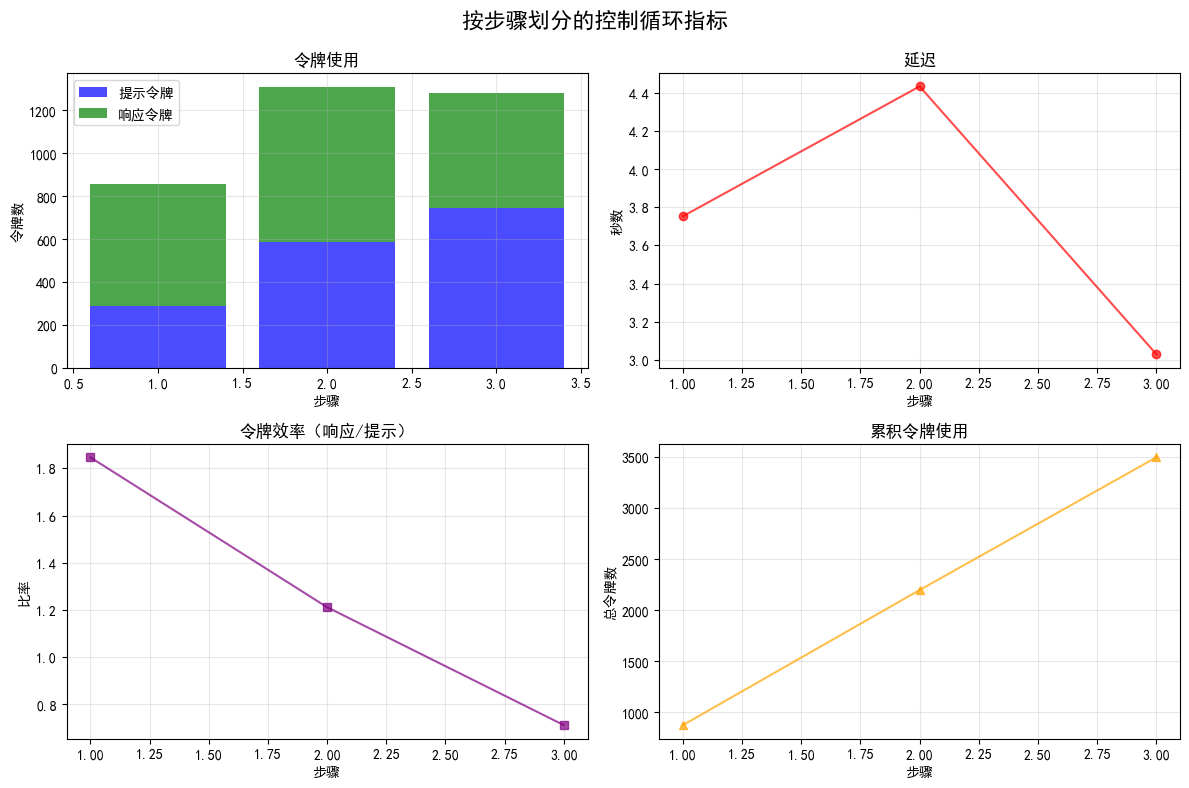

('简明总结报告\n\n本报告基于主要人物、企业及地点的关系分析，概述其创始、领导及行业地位：\n\n1. 创始与领导\n- 杰夫·贝佐斯于1995年在西雅图创立亚马逊，推动电子商务和云计算发展。\n- 埃隆·马斯克担任特斯拉CEO，并创立领导航天公司SpaceX，推动电动汽车和航天创新。\n- 比尔·盖茨1975年在阿尔伯克基联合创立微软，开启软件科技新时代。\n- 萨蒂亚·纳德拉现任微软CEO，持续推动公司技术创新与业务扩展。\n\n2. 地点关联\n- 亚马逊起源于美国华盛顿州西雅图。\n- 微软创立于美国新墨西哥州阿尔伯克基。\n\n3. 行业与竞争\n- 亚马逊、特斯拉、SpaceX和微软均为各自领域的全球领导者，涵盖电子商务、云计算、电动汽车、航天及软件科技。\n- 杰夫·贝佐斯和埃隆·马斯克曾交替成为世界首富，反映其在科技产业的显著影响力。\n- 萨蒂亚·纳德拉领导下的微软保持行业竞争力和持续创新。\n\n结论\n上述人物与企业在各自创立地点共同推动了科技创新及产业发展，且在财富与市场竞争中相互影响，彰显全球科技领域的领导力和创新活力。',
 {'initial_input': '\n    1995年，杰夫·贝佐斯在西雅图创立了亚马逊。最初是一家在线书店，\n    在贝佐斯的领导下亚马逊迅速扩张。到2021年，亚马逊已成为\n    世界上最有价值的公司之一，贝佐斯曾短暂超越\n    埃隆·马斯克成为世界首富。特斯拉和SpaceX的CEO马斯克，\n    在特斯拉股价飙升后重新夺回了榜首位置。与此同时，微软，\n    由比尔·盖茨于1975年在阿尔伯克基创立，在CEO萨蒂亚·纳德拉的领导下\n    继续成为主要的科技竞争对手。\n    ',
  'extract_entities': {'prompt': '从这段文本中提取主要实体（人物、地点、组织）。对每个实体提供简要描述。\n\n文本: \n    1995年，杰夫·贝佐斯在西雅图创立了亚马逊。最初是一家在线书店，\n    在贝佐斯的领导下亚马逊迅速扩张。到2021年，亚马逊已成为\n    世界上最有价值的公司之一，贝佐斯曾短暂超越\n    埃隆·马斯克成为世界首富。特斯拉和SpaceX的CEO马斯克，\n    在特斯拉股价飙升后重新夺回了榜首位置。与此同时，微软，\n   

In [17]:
example_sequential_chain()

2025-07-11 20:37:39,396 - __main__ - INFO - 生成初始回答
2025-07-11 20:37:42,758 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:37:42,761 - __main__ - INFO - 细化轮次 1/3
2025-07-11 20:37:46,030 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:37:46,035 - __main__ - INFO - 自动反馈：这段回答整体表达清晰，内容结构合理，涵盖了人工智能未来发展的多个重要领域及其潜在影响，且对机遇与挑战均有所提及，具有一定的深度和广度。具体评价如下：

优点：
1. 内容全面：涉及医疗、教育、交通、制造业等多个领域，展示了AI应用的多样性。
2. 结构清晰：先阐述AI的积极作用，再提出潜在问题，最后总结呼吁，逻辑顺畅。
3. 语言通顺：表达自然，易于理解。

不足与改进建议：
1. 细节不足：各领域的描述较为概括，缺少具体案例或数据支持，建议增加具体应用实例或最新研究成果，提高说服力。
2. 观点深度有限：对挑战的分析较为表面，未深入探讨隐私保护、伦理道德等问题的复杂性及可能的解决方案，可增加相关讨论。
3. 未来展望泛泛：关于“技术创新与社会规范的平衡”表述较宽泛，可具体说明如何实现这一平衡，如政策制定、公众参与、跨学科合作等。
4. 语言风格可更具吸引力：加入一些生动的比喻或形象的描述，使内容更具感染力和吸引力。

总体而言，该回答适合作为人工智能未来发展主题的简要介绍，若能结合更多具体细节和深入分析，内容将更具权威性和吸引力。
2025-07-11 20:37:52,724 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "

```
写一篇关于人工智能未来的短文。
```

人工智能（AI）作为现代科技的重要前沿，正深刻改变着我们的生活和社会。未来，人工智能有望在医疗、教育、交通、制造等多个领域发挥更加重要的作用。在医疗方面，AI可以辅助医生进行精准诊断和个性化治疗，提高治愈率和医疗效率。在教育领域，智能教学系统将根据学生的兴趣和能力，提供定制化的学习方案，促进因材施教。交通运输则可能实现无人驾驶技术的广泛应用，提升安全性和出行效率。此外，随着AI技术的不断进步，智能机器人将更好地协助人类完成复杂和危险的任务，解放人力资源。

然而，随着人工智能的普及，隐私保护、伦理道德和就业替代等问题也日益凸显。未来的发展需要在技术创新与社会规范之间找到平衡，确保人工智能造福全人类。总的来说，人工智能的未来充满机遇与挑战，我们应积极拥抱这一变革，推动科技与社会的和谐发展。

这段回答整体表达清晰，内容结构合理，涵盖了人工智能未来发展的多个重要领域及其潜在影响，且对机遇与挑战均有所提及，具有一定的深度和广度。具体评价如下：

优点：
1. 内容全面：涉及医疗、教育、交通、制造业等多个领域，展示了AI应用的多样性。
2. 结构清晰：先阐述AI的积极作用，再提出潜在问题，最后总结呼吁，逻辑顺畅。
3. 语言通顺：表达自然，易于理解。

不足与改进建议：
1. 细节不足：各领域的描述较为概括，缺少具体案例或数据支持，建议增加具体应用实例或最新研究成果，提高说服力。
2. 观点深度有限：对挑战的分析较为表面，未深入探讨隐私保护、伦理道德等问题的复杂性及可能的解决方案，可增加相关讨论。
3. 未来展望泛泛：关于“技术创新与社会规范的平衡”表述较宽泛，可具体说明如何实现这一平衡，如政策制定、公众参与、跨学科合作等。
4. 语言风格可更具吸引力：加入一些生动的比喻或形象的描述，使内容更具感染力和吸引力。

总体而言，该回答适合作为人工智能未来发展主题的简要介绍，若能结合更多具体细节和深入分析，内容将更具权威性和吸引力。

人工智能（AI）作为当今科技发展的前沿领域，正以惊人的速度深刻重塑我们的生活和社会结构。展望未来，人工智能将在医疗、教育、交通、制造等多个关键领域发挥更加举足轻重的作用。

在医疗领域，AI不仅能辅助医生实现精准诊断，还能通过大数据和机器学习技术，制定个性化治疗方案，显著提升治愈率和医疗效率。例如，谷歌旗下的DeepMind项目已成功开发出能够准确预测眼科疾病的AI系统，帮助临床医生提前干预，挽救患者视力。在教育方面，智能教学系统能够根据学生的兴趣、学习习惯和能力差异，量身定制个性化学习路径，实现真正的因材施教。像Knewton和Squirrel AI等平台，已经在自适应学习领域取得突破，极大提升了学习效果。交通运输领域，随着特斯拉、百度Apollo等无人驾驶技术的成熟，未来智能汽车有望减少交通事故、缓解拥堵，实现更安全、高效的出行体验。同时，制造业正借助AI优化生产流程和质量控制，推动智能工厂的建设，提升产业竞争力。智能机器人则将在执行复杂、危险任务方面大显身手，如灾难救援、深海探测等，解放人类劳动力，保障生命安全。

然而，随着人工智能的广泛应用，隐私保护、伦理道德、就业替代等问题日益突出，成为亟需解决的社会难题。隐私方面，AI数据的采集与使用可能侵犯个人信息安全，如何通过严格的数据管理和加密技术保障用户隐私，是技术和法律共同面临的挑战。伦理层面，自动决策系统可能引发偏见和歧视，制定透明、公正的算法标准和监管机制尤为关键。就业替代则涉及产业转型和劳动力再培训，政府和企业需协同推动教育改革和职业技能提升，缓解就业压力。

未来，人工智能的发展必须在技术创新与社会规范之间找到科学平衡。具体来说，应加强政策制定，构建完善的法律法规体系；鼓励公众参与和多方对话，提升社会认知和接受度；推动跨学科

```
提示令牌数: 971 | 响应令牌数: 901 | 总令牌数: 1885 | 延迟: 6.69秒 | 令牌效率: 0.92
```

这段回答内容全面，结构清晰，涵盖了人工智能在多个领域的应用及其带来的社会问题，展望了未来发展的方向，体现出较强的逻辑性和信息量，整体质量较高。但仍有提升空间，具体建议如下：

1. **内容完整性**  
   回答末尾“推动跨学科”后未完成，导致内容不完整，建议补充完整句子，使论述更加连贯完整。

2. **细节深入度**  
   目前对各领域应用的介绍较为概括，建议增加更多具体案例或最新技术进展，增强说服力和权威感。例如医疗领域可补充更多AI如何辅助疾病预测、药物研发的实例。

3. **语言表达**  
   语言整体较正式，但部分句子略长且信息密集，容易造成理解负担。建议适当拆分长句，使用更简洁明了的表达，使内容更易读。

4. **平衡视角**  
   对AI负面影响的描述较为详细，但对其带来的积极社会变革和促进人类福祉的展望相对不足。建议在结尾部分强化AI促进社会进步的积极面，形成更加全面的评价。

5. **逻辑衔接**  
   各段之间的过渡部分可以更自然些，增加承接句或过渡语，使文章流畅度提升。

6. **术语解释**  
   对于专业名词如“自适应学习”、“自动决策系统”等，建议简要解释，方便不同背景读者理解。

总结：该回答内容丰富，结构合理，基本满足高质量标准。通过补充完整内容、丰富案例、优化语言表达和增强逻辑衔接，可进一步提升阅读体验和专业度。

人工智能（AI）作为当今科技发展的前沿领域，正以惊人的速度深刻重塑我们的生活和社会结构。展望未来，人工智能将在医疗、教育、交通、制造等多个关键领域发挥愈加重要的作用。

在医疗领域，AI不仅辅助医生实现精准诊断，还通过大数据分析和机器学习技术，制定个性化治疗方案，显著提升治愈率和医疗效率。例如，谷歌旗下的DeepMind项目开发的AI系统，能够准确预测眼科疾病，帮助临床医生提前干预，挽救患者视力。此外，AI还推动了药物研发的创新，如利用深度学习加速新药分子的筛选和优化，缩短研发周期。类似IBM Watson Health通过整合海量医学文献，为临床决策提供智能支持，提升诊疗水平。

在教育方面，智能教学系统能够根据学生的兴趣、学习习惯和能力差异，量身定制个性化学习路径，实现真正的因材施教。所谓“自适应学习”系统，指的是通过持续收集和分析学生的学习数据，动态调整教学内容和难度，最大化学习效果。以Knewton和Squirrel AI为代表的自适应学习平台，已经在提升学生成绩和学习积极性方面取得显著成效，推动教育公平和质量提升。

交通运输领域，随着特斯拉、百度Apollo等无人驾驶技术的快速发展，智能汽车有望大幅减少交通事故、缓解城市拥堵，提升出行安全与效率。同时，AI还支持智能交通管理系统，通过实时监控和数据分析，优化信号灯控制和路线规划，促进绿色出行。制造业则借助AI优化生产流程和质量控制，推动智能工厂建设，提升产业竞争力。智能机器人在执行复杂、危险任务方面表现出色，如灾难救援、深海探测等，不仅解放人类劳动力，还保障了生命安全。

然而，随着人工智能的广泛应用，隐私保护、伦理道德和就业替代等问题日益突出，成为亟需解决的社会难题。在隐私方面，AI的数据采集与使用可能侵犯个人信息安全，如何通过严格的数据管理、加密技术和法律规范保障用户

```
提示令牌数: 1558 | 响应令牌数: 897 | 总令牌数: 2468 | 延迟: 4.91秒 | 令牌效率: 0.57
```


        - 初始提示令牌数: 19
        - 初始回答令牌数: 420
        - 总细化轮数: 2
        - 最终回答令牌数: 897
        

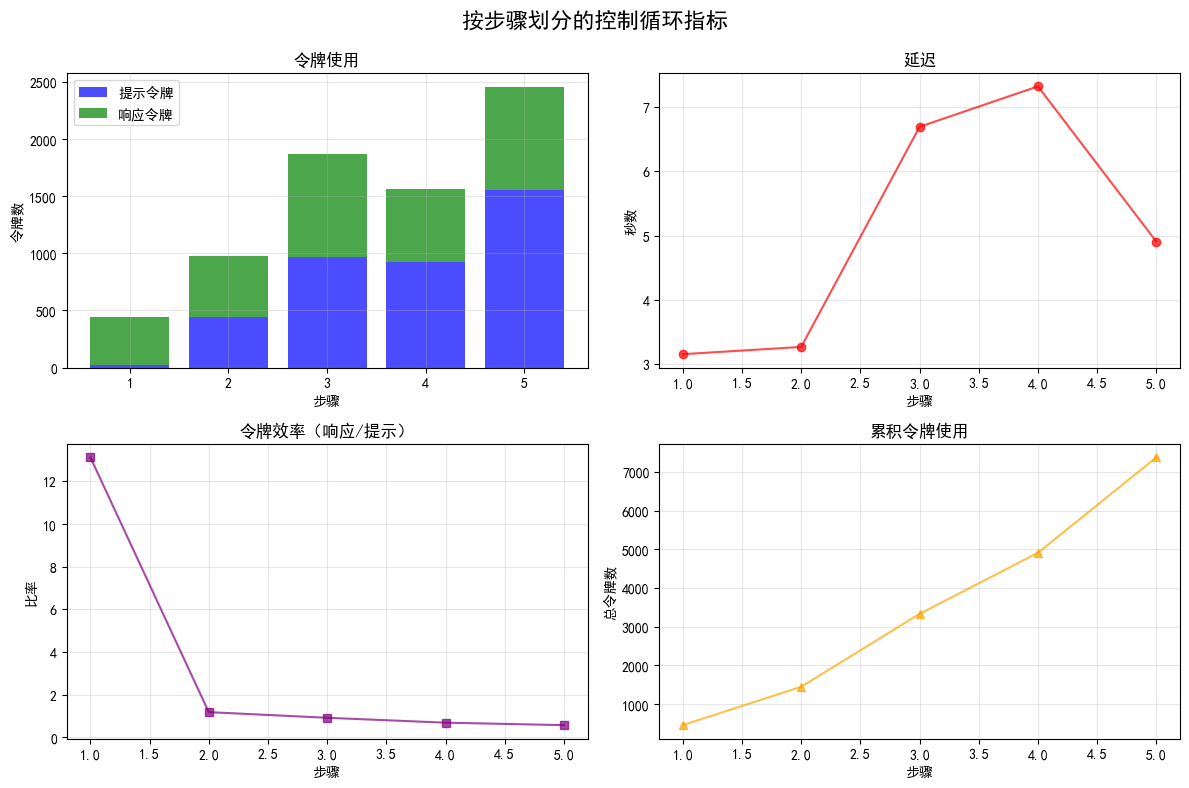

('人工智能（AI）作为当今科技发展的前沿领域，正以惊人的速度深刻重塑我们的生活和社会结构。展望未来，人工智能将在医疗、教育、交通、制造等多个关键领域发挥愈加重要的作用。\n\n在医疗领域，AI不仅辅助医生实现精准诊断，还通过大数据分析和机器学习技术，制定个性化治疗方案，显著提升治愈率和医疗效率。例如，谷歌旗下的DeepMind项目开发的AI系统，能够准确预测眼科疾病，帮助临床医生提前干预，挽救患者视力。此外，AI还推动了药物研发的创新，如利用深度学习加速新药分子的筛选和优化，缩短研发周期。类似IBM Watson Health通过整合海量医学文献，为临床决策提供智能支持，提升诊疗水平。\n\n在教育方面，智能教学系统能够根据学生的兴趣、学习习惯和能力差异，量身定制个性化学习路径，实现真正的因材施教。所谓“自适应学习”系统，指的是通过持续收集和分析学生的学习数据，动态调整教学内容和难度，最大化学习效果。以Knewton和Squirrel AI为代表的自适应学习平台，已经在提升学生成绩和学习积极性方面取得显著成效，推动教育公平和质量提升。\n\n交通运输领域，随着特斯拉、百度Apollo等无人驾驶技术的快速发展，智能汽车有望大幅减少交通事故、缓解城市拥堵，提升出行安全与效率。同时，AI还支持智能交通管理系统，通过实时监控和数据分析，优化信号灯控制和路线规划，促进绿色出行。制造业则借助AI优化生产流程和质量控制，推动智能工厂建设，提升产业竞争力。智能机器人在执行复杂、危险任务方面表现出色，如灾难救援、深海探测等，不仅解放人类劳动力，还保障了生命安全。\n\n然而，随着人工智能的广泛应用，隐私保护、伦理道德和就业替代等问题日益突出，成为亟需解决的社会难题。在隐私方面，AI的数据采集与使用可能侵犯个人信息安全，如何通过严格的数据管理、加密技术和法律规范保障用户',
 {'initial': {'prompt': '写一篇关于人工智能未来的短文。',
   'response': '人工智能（AI）作为现代科技的重要前沿，正深刻改变着我们的生活和社会。未来，人工智能有望在医疗、教育、交通、制造等多个领域发挥更加重要的作用。在医疗方面，AI可以辅助医生进行精准诊断和个性化治疗，提高治愈率和医疗效率。在教育领域，智能教学系统将根据学生的兴趣和能力，提供定制化的学习方案，促进因材施

In [15]:
example_iterative_refiner()

2025-07-11 20:39:05,630 - __main__ - INFO - 正在分类输入
2025-07-11 20:39:07,241 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:39:07,246 - __main__ - INFO - 执行分支: simplified
2025-07-11 20:39:09,040 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"


量子计算是如何工作的？

选定分支: **simplified**

```
提示令牌数: 40 | 响应令牌数: 5 | 总令牌数: 63 | 延迟: 1.62秒 | 令牌效率: 0.09
```

**simplified**

好的！想象你有一个超级神奇的魔法盒子，它可以同时试很多不同的答案，而不是像普通电脑那样一个一个试。量子计算就是用这种魔法盒子来解决很难的问题。

普通电脑用“开”和“关”（就是0和1）来工作，就像灯泡开着或关着。但量子计算机用的是叫“量子比特”的小东西，这些小东西可以同时是“开”和“关”，像魔法一样。

因为它们能同时做很多事情，量子计算机能比普通电脑更快地解决某些特别难的问题，比如找大宝藏或者破解超级复杂的谜题。

总结就是：量子计算机用神奇的“量子比特”，能同时尝试很多答案，所以它非常聪明，可以快速解决普通电脑做起来很难的问题。

```
提示令牌数: 33 | 响应令牌数: 306 | 总令牌数: 366 | 延迟: 1.80秒 | 令牌效率: 5.10
```

2025-07-11 20:39:09,072 - __main__ - INFO - 正在分类输入
2025-07-11 20:39:21,349 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:39:21,351 - __main__ - INFO - 执行分支: simplified
2025-07-11 20:39:22,776 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"


什么是气候变化？

选定分支: **simplified**

```
提示令牌数: 40 | 响应令牌数: 5 | 总令牌数: 63 | 延迟: 12.28秒 | 令牌效率: 0.09
```

**simplified**

好的！气候变化就是说地球的天气和气温慢慢地发生了大变化。比如，有时候会变得比以前更热，或者下雨和下雪的方式也不一样了。这个变化是因为人们用汽车、工厂和砍树，让空气里有了很多叫做“二氧化碳”的气体，这些气体就像一层厚厚的毯子把地球包起来，让地球变暖了。气候变化会影响动物、植物，还有我们生活的地方，所以我们要保护地球，减少这些气体，让地球变得更健康。

```
提示令牌数: 33 | 响应令牌数: 215 | 总令牌数: 275 | 延迟: 1.43秒 | 令牌效率: 3.58
```

2025-07-11 20:39:22,801 - __main__ - INFO - 正在分类输入
2025-07-11 20:39:23,564 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:39:23,567 - __main__ - INFO - 执行分支: practical
2025-07-11 20:39:27,015 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"


我该如何提高公众演讲技巧？

选定分支: **practical**

```
提示令牌数: 46 | 响应令牌数: 5 | 总令牌数: 69 | 延迟: 0.76秒 | 令牌效率: 0.08
```

**practical**

提高公众演讲技巧，关键在于系统练习和有效准备。以下是具体、可操作的建议：

1. 明确演讲目标和受众  
   - 在准备演讲前，明确你想传达的核心信息。  
   - 了解听众的背景、兴趣和需求，调整内容和语言风格。

2. 制定结构清晰的演讲大纲  
   - 开头吸引注意力（故事、问题、数据等）。  
   - 主体部分分点阐述，逻辑清晰。  
   - 结尾总结重点并呼吁行动。

3. 多次练习  
   - 对着镜子练习，注意表情和肢体语言。  
   - 用手机录音或录像，回看并改进。  
   - 进行模拟演讲，邀请朋友或同事给予反馈。

4. 控制紧张情绪  
   - 演讲前深呼吸，做放松练习。  
   - 通过充分准备建立自信。  
   - 视听众为朋友，减少心理压力。

5. 注重非语言沟通  
   - 保持眼神交流，增强互动感。  
   - 使用适当的手势辅助表达。  
   - 控制语速和音量，避免单调。

6. 利用视觉辅助工具  
   - 制作简洁明了的PPT或图表，突出重点。  
   - 不要过度依赖幻灯片，保持与听众的互动。

7. 持续学习和改进  
   - 观看优秀演讲视频，学习技巧。  
   - 参加演讲培训班或加入演讲俱乐部（如Toastmasters）。  
   - 不断积累演讲经验，逐步提升。

通过以上步骤，逐步提升你的公众演讲能力，做到内容丰富、表达自信、感染力强。

```
提示令牌数: 35 | 响应令牌数: 613 | 总令牌数: 667 | 延迟: 3.45秒 | 令牌效率: 11.35
```

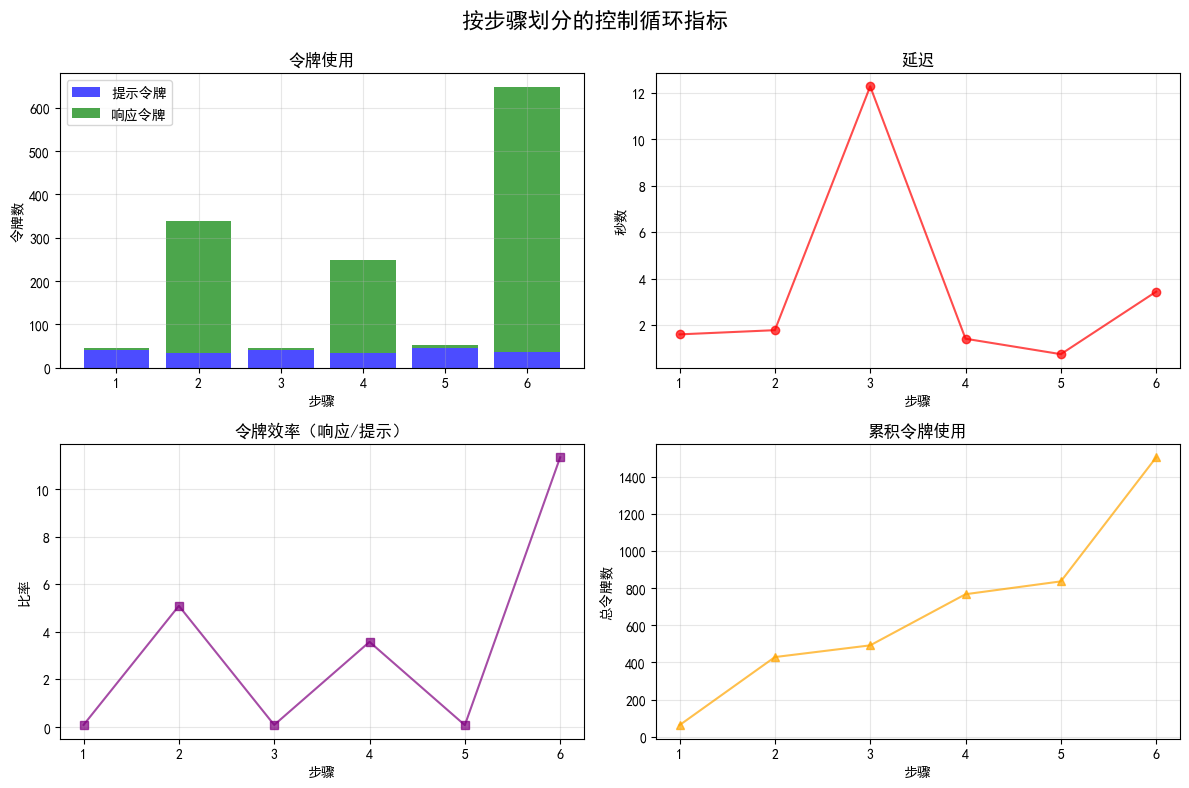

[('量子计算是如何工作的？',
  '好的！想象你有一个超级神奇的魔法盒子，它可以同时试很多不同的答案，而不是像普通电脑那样一个一个试。量子计算就是用这种魔法盒子来解决很难的问题。\n\n普通电脑用“开”和“关”（就是0和1）来工作，就像灯泡开着或关着。但量子计算机用的是叫“量子比特”的小东西，这些小东西可以同时是“开”和“关”，像魔法一样。\n\n因为它们能同时做很多事情，量子计算机能比普通电脑更快地解决某些特别难的问题，比如找大宝藏或者破解超级复杂的谜题。\n\n总结就是：量子计算机用神奇的“量子比特”，能同时尝试很多答案，所以它非常聪明，可以快速解决普通电脑做起来很难的问题。',
  {'input': '量子计算是如何工作的？',
   'classification': {'branch': 'simplified',
    'metrics': {'prompt_tokens': 40,
     'system_tokens': 18,
     'model': 'openai/gpt-4.1-mini',
     'temperature': 0.7,
     'max_tokens': 500,
     'timestamp': 1752237545.6314738,
     'latency': 1.6154792308807373,
     'response_tokens': 5,
     'total_tokens': 63,
     'token_efficiency': 0.08620689655172414,
     'tokens_per_second': 3.0950568131253955}},
   'execution': {'branch': 'simplified',
    'response': '好的！想象你有一个超级神奇的魔法盒子，它可以同时试很多不同的答案，而不是像普通电脑那样一个一个试。量子计算就是用这种魔法盒子来解决很难的问题。\n\n普通电脑用“开”和“关”（就是0和1）来工作，就像灯泡开着或关着。但量子计算机用的是叫“量子比特”的小东西，这些小东西可以同时是“开”和“关”，像魔法一样。\n\n因为它们能同时做很多事情，量子计算机能比普通电脑更快地解决某些特别难的问题，比如找大宝藏或

In [16]:
example_conditional_brancher()

2025-07-11 20:43:45,991 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:43:45,997 - __main__ - INFO - 未能从响应中解析出各部分


第一次世界大战的主要原因是什么，它们是如何导致冲突的？

```
提示令牌数: 189 | 响应令牌数: 790 | 总令牌数: 992 | 延迟: 4.59秒 | 令牌效率: 3.91
```

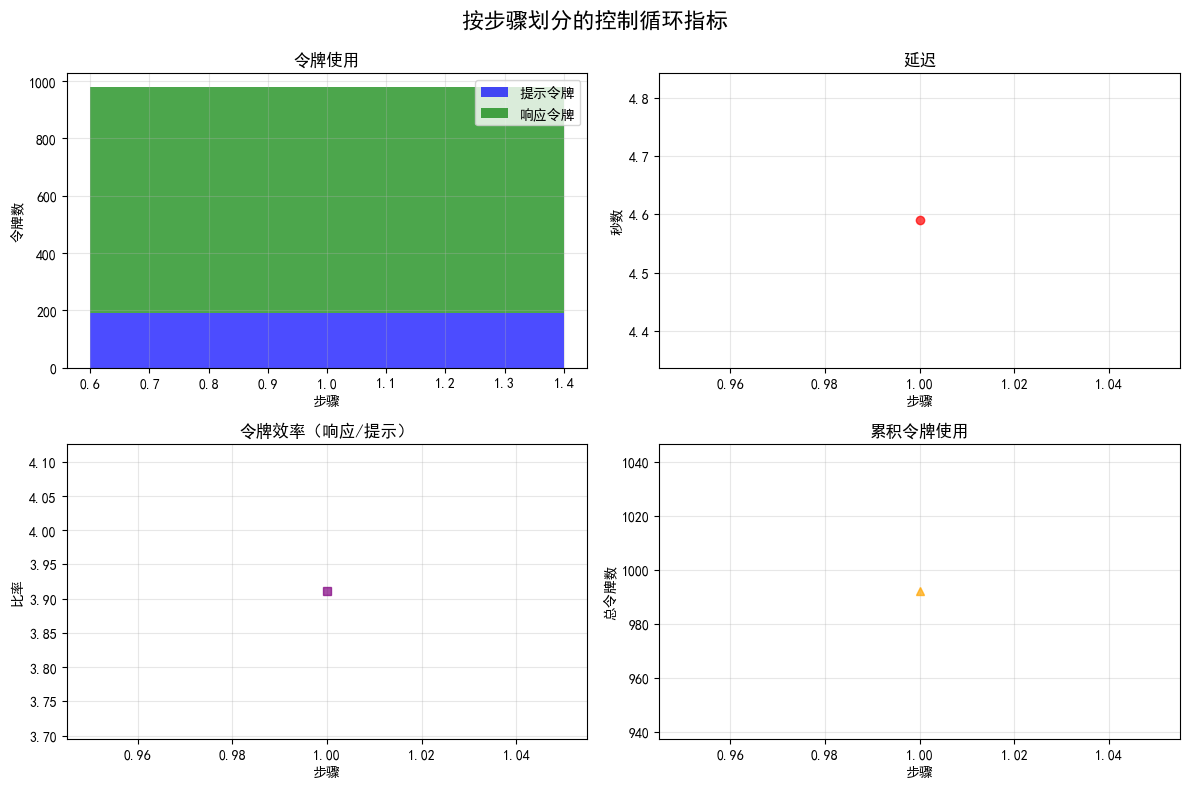

('第1步：初始回答\n\n第一次世界大战的主要原因包括军事同盟体系的形成、民族主义的兴起、军备竞赛和帝国主义的扩张，以及直接导火索——萨拉热窝事件。具体来说，19世纪末和20世纪初，欧洲列强为了保护自身利益，建立了复杂的军事同盟体系，如三国协约（英国、法国、俄罗斯）和三国同盟（德国、奥匈帝国、意大利）。这种体系使得局部冲突容易升级为大规模战争。\n\n民族主义的兴起激发了各民族对独立和国家利益的追求，特别是在奥匈帝国和巴尔干地区，激化了紧张局势。与此同时，主要大国之间的军备竞赛加剧了紧张感，尤其是德国和英国在海军力量上的竞争。帝国主义的扩张导致了殖民地争夺和利益冲突，进一步加剧了大国间的敌对。\n\n1914年6月28日，奥匈帝国皇储弗朗茨·斐迪南大公在萨拉热窝被塞尔维亚民族主义者刺杀，这一事件成为战争的直接导火索。随后，奥匈帝国向塞尔维亚宣战，因同盟体系的连锁反应，欧洲迅速陷入全面战争。\n\n第2步：批判性审查\n\n- 事实准确性：初始回答整体准确，涵盖了主要原因和导火索。\n- 缺失重要信息：未提及“危机事件”（如摩洛哥危机、巴尔干战争）对加剧紧张的影响；未强调“德国的威胁感”及其对欧洲平衡的冲击；未提及奥匈帝国对塞尔维亚的强硬态度和德国的支持。\n- 潜在偏见：回答较为中立，但未表现出各方责任的复杂性，有简化倾向。\n- 不确定之处：对帝国主义和军备竞赛的具体表现和影响可以进一步细化。\n\n第3步：改进的最终回答\n\n第一次世界大战的主要原因是多方面且复杂的，主要包括军事同盟体系的',
 {'input': '第一次世界大战的主要原因是什么，它们是如何导致冲突的？',
  'full_response': '第1步：初始回答\n\n第一次世界大战的主要原因包括军事同盟体系的形成、民族主义的兴起、军备竞赛和帝国主义的扩张，以及直接导火索——萨拉热窝事件。具体来说，19世纪末和20世纪初，欧洲列强为了保护自身利益，建立了复杂的军事同盟体系，如三国协约（英国、法国、俄罗斯）和三国同盟（德国、奥匈帝国、意大利）。这种体系使得局部冲突容易升级为大规模战争。\n\n民族主义的兴起激发了各民族对独立和国家利益的追求，特别是在奥匈帝国和巴尔干地区，激化了紧张局势。与此同时，主要大国之间的军备竞赛加剧了紧张感，尤其是德国和英国在海军力量上的竞争。帝国主义的扩张导致了殖

In [23]:
example_self_critique()

2025-07-11 20:43:59,456 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 20:43:59,460 - __main__ - INFO - 正在验证第 1 次尝试
2025-07-11 20:43:59,462 - __main__ - INFO - 第 1 次尝试获得有效回答


编写一个Python函数来检查字符串是否为回文。

当然！下面是一个简单的Python函数，用来检查一个字符串是否为回文（即正着读和反着读都一样）：

```python
def is_palindrome(s: str) -> bool:
    # 去除字符串中的空格，并转为统一大小写
    s = s.replace(" ", "").lower()
    # 判断字符串是否等于其反转
    return s == s[::-1]

# 测试
print(is_palindrome("level"))       # True
print(is_palindrome("A man a plan a canal Panama"))  # True
print(is_palindrome("hello"))       # False
```

这个函数会忽略大小写和空格。如果你还想忽略标点符号，可以进一步处理字符串。需要的话我也可以帮你写。

```
提示令牌数: 14 | 响应令牌数: 193 | 总令牌数: 220 | 延迟: 2.35秒 | 令牌效率: 7.15
```


        - 最终状态: **✓ 有效**
        - 总尝试次数: 1
        - 总令牌数: 220
        - 总延迟: 2.35秒
        

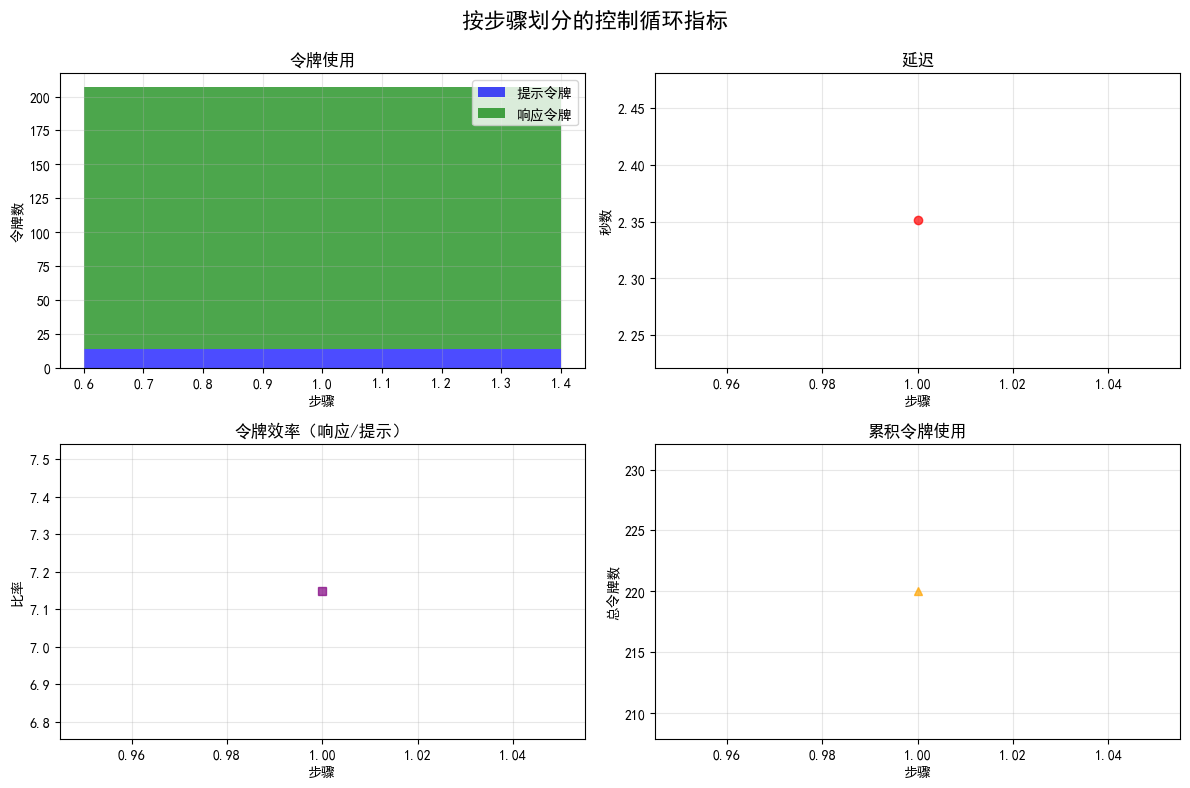

('当然！下面是一个简单的Python函数，用来检查一个字符串是否为回文（即正着读和反着读都一样）：\n\n```python\ndef is_palindrome(s: str) -> bool:\n    # 去除字符串中的空格，并转为统一大小写\n    s = s.replace(" ", "").lower()\n    # 判断字符串是否等于其反转\n    return s == s[::-1]\n\n# 测试\nprint(is_palindrome("level"))       # True\nprint(is_palindrome("A man a plan a canal Panama"))  # True\nprint(is_palindrome("hello"))       # False\n```\n\n这个函数会忽略大小写和空格。如果你还想忽略标点符号，可以进一步处理字符串。需要的话我也可以帮你写。',
 {'input': '编写一个Python函数来检查字符串是否为回文。',
  'attempts': [{'attempt': 1,
    'response': '当然！下面是一个简单的Python函数，用来检查一个字符串是否为回文（即正着读和反着读都一样）：\n\n```python\ndef is_palindrome(s: str) -> bool:\n    # 去除字符串中的空格，并转为统一大小写\n    s = s.replace(" ", "").lower()\n    # 判断字符串是否等于其反转\n    return s == s[::-1]\n\n# 测试\nprint(is_palindrome("level"))       # True\nprint(is_palindrome("A man a plan a canal Panama"))  # True\nprint(is_palindrome("hello"))       # False\n```\n\n这个函数会忽略大小写和空格。如果你还想忽略标点符号，可以进一步处理字符串。需要的话我也可以帮你写。',
    'metrics': {'prompt_tokens': 14,
     'system_tokens': 13,
   

In [24]:
example_external_validation()